## Project 7

**Mohammad Kamal Sadeghabadi Farahani**

### Description

In this project we have implemented RSTDP and FlatRSTDP learning rules, then we will create a network with two output neurons and two diffrent input patterns and use RSTDP and FlatRSTDP in our network to learn these patterns.

### Training technique

We will consider a three times bigger punishment compared to reward, first we will train our network with the pattern 1 then we will give 2 seconds rest to our network so the dopamin returns to zero, then we will train the network with the pattern 2.

In [17]:
import torch
import sys
import copy
import matplotlib.pyplot as plt

sys.path.insert(0, '../../')

from cnsproject.plotting.plotting import raster_plot, plot_weights, plot_dopamin
from cnsproject.encoding.encoders import PoissonEncoder
from cnsproject.network.neural_populations import InputPopulation, LIFPopulation
from cnsproject.network.connections import DenseConnection
from cnsproject.learning.learning_rules import RSTDP, FlatRSTDP
from cnsproject.learning.rewards import SimpleReward

In [13]:
def my_reward(pattern, out_spikes):
    if pattern == 0:
        return (out_spikes[0].long() + -3 * out_spikes[1].long())
    else:
        return (-3 * out_spikes[0].long() + out_spikes[1].long())

In [21]:
def train_network_RSTDP(time, dt, tau_s, max_spikes, lr, tau_c, tau_d, LEARNING_RULE):
    pattern1 = torch.tensor([1, 1, 0, 0])
    pattern2 = torch.tensor([0, 0, 1, 1])
    
    min_val = 0
    max_val = 1
    steps = int(time / dt)
    
    tau = 0.1
    threshold = -60
    rest_potential = -65
    
    encoder = PoissonEncoder(time=time, max_spikes=max_spikes, dt=dt)
    coded1 = encoder(min_val, max_val, pattern1)
    coded2 = encoder(min_val, max_val, pattern2)
    
    input_pop = InputPopulation(pattern1.shape, dt=dt, tau_s= tau_s)
    output_pop = LIFPopulation((2,), dt=dt, tau_s=tau_s, threshold=threshold, rest_potential=rest_potential, tau=tau)
    
    synapse = DenseConnection(input_pop, output_pop, lr=lr, tau_c=tau_c, learning_rule=LEARNING_RULE)
    reward = SimpleReward(tau_d=tau_d, dt=dt)
    
    weights = []
    dops = []
    
    for i in range(steps):
        pattern = 0
        spikes = coded1[i]
        rewarded_dopamin = my_reward(pattern, output_pop.s)
        dopamin = reward.compute(rewarded_dopamin=rewarded_dopamin)
        spike_effects = synapse.compute(input_pop.s)
        synapse.update(dopamin=dopamin)

        input_pop.forward(spikes, None)
        output_pop.forward(torch.zeros(output_pop.shape), spike_effects)
        weights.append(copy.deepcopy(synapse.weight))
        dops.append(copy.deepcopy(dopamin))
        
    
    for i in range(int(2 / dt)):
        spikes = torch.zeros(coded1[i].shape)
        dopamin = reward.compute(rewarded_dopamin=0)
        spike_effects = synapse.compute(input_pop.s)
        synapse.update(dopamin=dopamin)

        input_pop.forward(spikes, None)
        output_pop.forward(torch.zeros(output_pop.shape), spike_effects)
        weights.append(copy.deepcopy(synapse.weight))
        dops.append(copy.deepcopy(dopamin))
    
    for i in range(steps):
        pattern = 1
        spikes = coded2[i]
        rewarded_dopamin = my_reward(pattern, output_pop.s)
        dopamin = reward.compute(rewarded_dopamin=rewarded_dopamin)
        spike_effects = synapse.compute(input_pop.s)
        synapse.update(dopamin=dopamin)

        input_pop.forward(spikes, None)
        output_pop.forward(torch.zeros(output_pop.shape), spike_effects)
        weights.append(copy.deepcopy(synapse.weight))
        dops.append(copy.deepcopy(dopamin))
    
    
    print('Dopamin changes:')
    plot_dopamin(dops, dt)
    
    print('Weights changes plot:')
    plot_weights(weights, dt)
    
    
    test_time = 1
    steps_test = int(test_time / dt)
    encoder_test = PoissonEncoder(time=test_time, max_spikes=int(max_spikes * (time / test_time)  ), dt=dt)
    coded_test1 = encoder(min_val, max_val, pattern1)
    coded_test2 = encoder(min_val, max_val, pattern2)
    
    spikes_in = []
    spikes_out = []
    
    switch_interval = 100
    for i in range(int(steps_test / switch_interval)):
        for j in range(i * switch_interval, (i + 1) * switch_interval):
            spike_effects = synapse.compute(input_pop.s)

            selector = i % 2
            if selector == 0:
                spikes = coded_test1[j]
            elif selector == 1:
                spikes = coded_test2[j]

            input_pop.forward(spikes, None)
            output_pop.forward(torch.zeros(output_pop.shape), spike_effects)

            spikes_in.append(input_pop.s)
            spikes_out.append(output_pop.s)

    
    print('Rater plot of testing with patterns: ')
    raster_plot([spikes_in, spikes_out], dt)

### RSTDP

### Experiment 1

Dopamin changes:


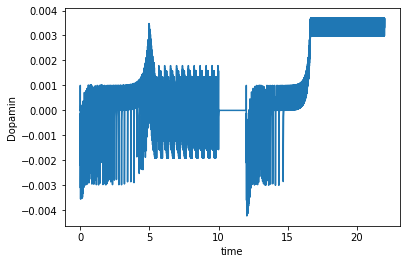

Weights changes plot:


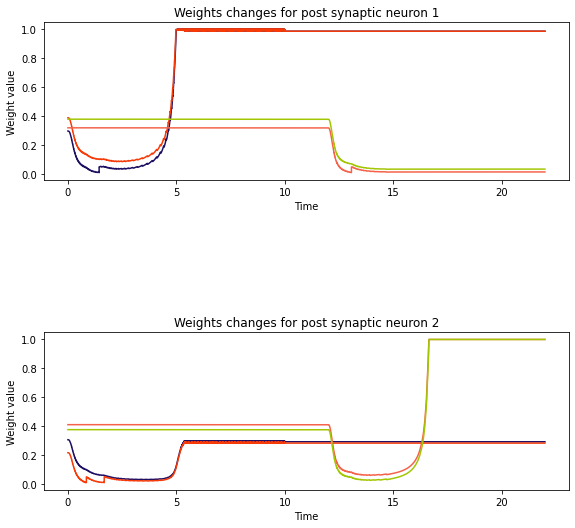

Rater plot of testing with patterns: 


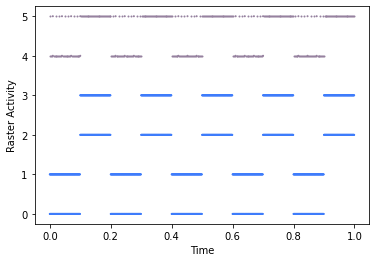

In [26]:
train_network_RSTDP(time=10, dt=0.001, tau_s=0.1, max_spikes=10000, lr=1, tau_c=0.1, tau_d=0.01, LEARNING_RULE=RSTDP)

### Analysis of experiment 1

| training time | $\tau_c$ | $\tau_s$ | $\tau_d$ | learning rate | r_max |
| ------------- | ------- | -------- | ------- |------------- | ----- |
|     22**s**   |    0.1  |    0.1   |    0.01 |    1        |  10000 |

As we can see at the start of the training the dopamin level goes down becuase the unwanted results has bigger punishment than the rewards of wanted results, so the weights from neurons 1 and 2 of input population to both outputs neurons decay untill we have less unwanted results and more wanted results at this point the dopamin starts to increase and thus the weights between neurons 1 and 2 of the input population and neuron 1 and 2 in the output population starts to increase but the weights between neurons 1 and 2 in the input population and neuron 2 in the output population will not increase alot becuase of punishments. the same events happen when we train the network with the patter 2.

### Experiment 2

Dopamin changes:


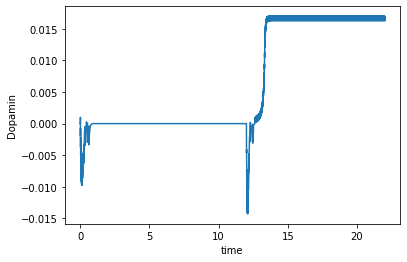

Weights changes plot:


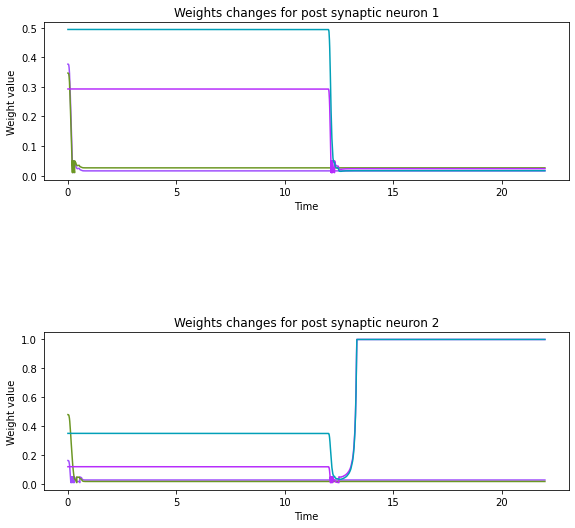

Rater plot of testing with patterns: 


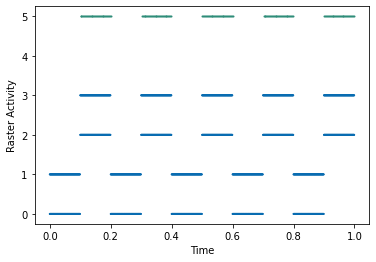

In [29]:
train_network_RSTDP(time=10, dt=0.001, tau_s=0.1, max_spikes=10000, lr=1, tau_c=0.1, tau_d=0.05, LEARNING_RULE=RSTDP)

### Analysis of experiment 2

| training time | $\tau_c$ | $\tau_s$ | $\tau_d$ | learning rate | r_max |
| ------------- | ------- | -------- | ------- |------------- | ----- |
|     22**s**   |    0.1  |    0.1   |    0.05 |    1        |  10000 |

Here we have the same events as the previous experiment 1 but because we have a five times bigger $\tau_d$ here, even the beneficial weights in the process of training of the pattern 1 decayed and didn't find the chanse to increase again because the dopamin effects of punishments remained longer.

### Experiment 3

Dopamin changes:


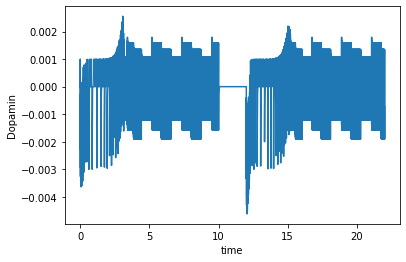

Weights changes plot:


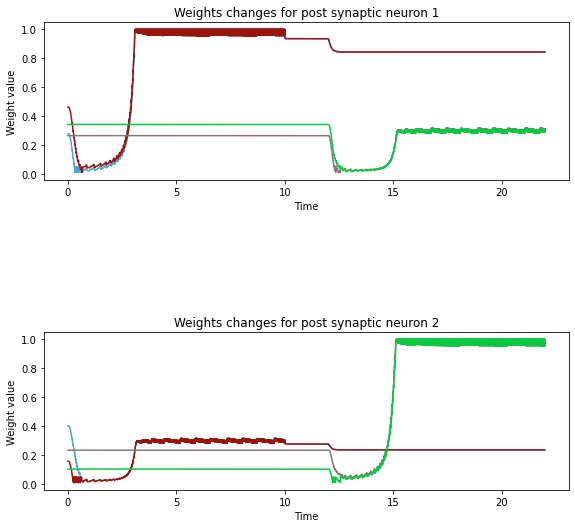

Rater plot of testing with patterns: 


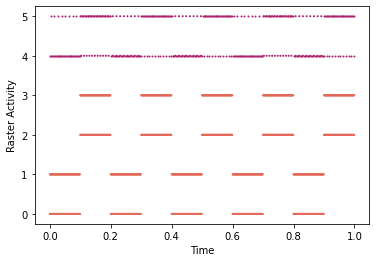

In [30]:
train_network_RSTDP(time=10, dt=0.001, tau_s=0.1, max_spikes=10000, lr=1, tau_c=0.5, tau_d=0.01, LEARNING_RULE=RSTDP)

### Analysis of experiment 3

| training time | $\tau_c$ | $\tau_s$ | $\tau_d$ | learning rate | r_max |
| ------------- | ------- | -------- | ------- |------------- | ----- |
|     22**s**   |    0.5  |    0.1   |    0.01 |    1        |  10000 |

Here we have a five time bigger $\tau_c$ compared to experiment 1, this will cause the synaptics tags remain loner and thus higher amount of change in weights for each reward and punishment.

### Flat RSTDP

### Experiment 1

Dopamin changes:


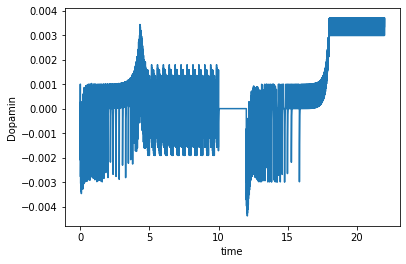

Weights changes plot:


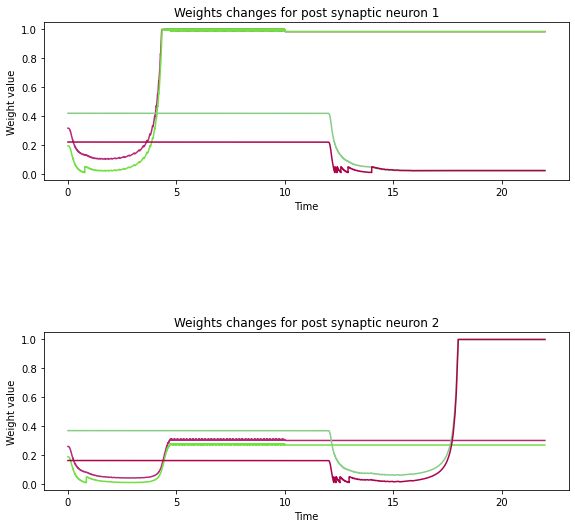

Rater plot of testing with patterns: 


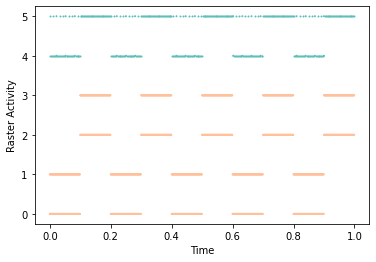

In [32]:
train_network_RSTDP(time=10, dt=0.001, tau_s=0.1, max_spikes=10000, lr=1, tau_c=0.1, tau_d=0.01, LEARNING_RULE=FlatRSTDP)

### Analysis of experiment 1

| training time | $\tau_c$ | $\tau_s$ | $\tau_d$ | learning rate | r_max |
| ------------- | ------- | -------- | ------- |------------- | ----- |
|     22**s**   |    0.1  |    0.1   |    0.01 |    1        |  10000 |

All events are the same as expriment 1 of RSTDP, except that here because we use Flat RSTDP the traces are keep for a time window (here 100 miliseconds) and the weight changes may be a little slower compared to RSTDP.

### Experiment 2

Dopamin changes:


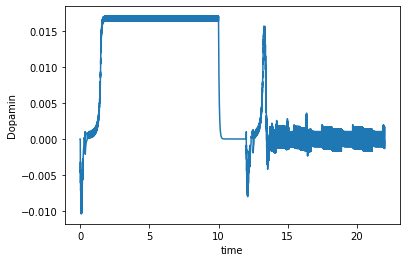

Weights changes plot:


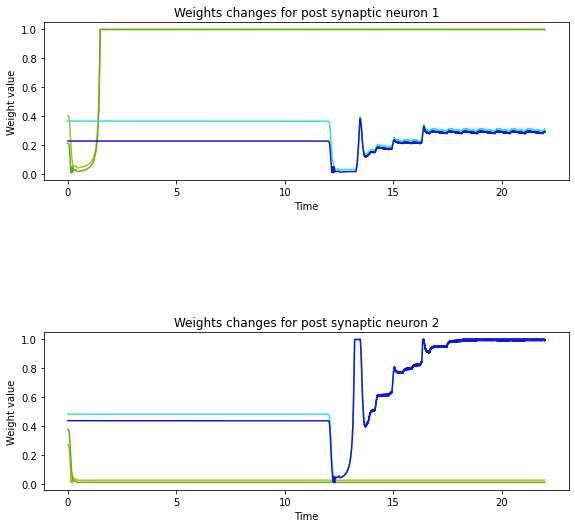

Rater plot of testing with patterns: 


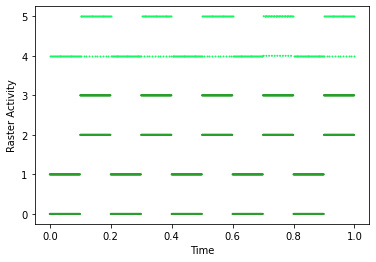

In [35]:
train_network_RSTDP(time=10, dt=0.001, tau_s=0.1, max_spikes=10000, lr=1, tau_c=0.1, tau_d=0.05, LEARNING_RULE=FlatRSTDP)

### Analysis of experiment 2

| training time | $\tau_c$ | $\tau_s$ | $\tau_d$ | learning rate | r_max |
| ------------- | ------- | -------- | ------- |------------- | ----- |
|     22**s**   |    0.1  |    0.1   |    0.05 |    1        |  10000 |

Here we have a five times bigger $\tau_d$ compared to experiment 1, as we can see here opposed to experiment 2 of RSTDP here two patterns are learned, one reason is becuase we have Flat RSTDP here and thus the synaptic tags doesn't get much high and thus the desired weights in pattern one can find a chanse to increase easier (the effect of negative dopamine does not vanish the weights as fast as experiment 2 of RSTDP).

### Experiment 3

Dopamin changes:


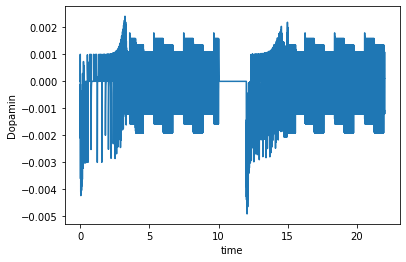

Weights changes plot:


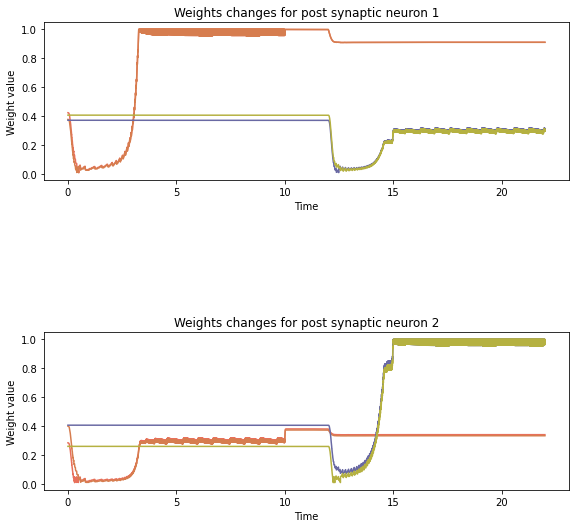

Rater plot of testing with patterns: 


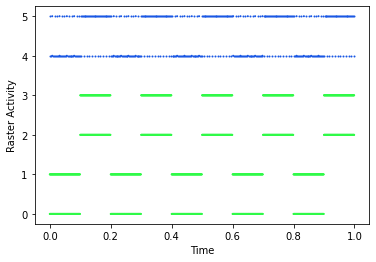

In [37]:
train_network_RSTDP(time=10, dt=0.001, tau_s=0.1, max_spikes=10000, lr=1, tau_c=0.5, tau_d=0.01, LEARNING_RULE=FlatRSTDP)

### Analysis of experiment 3

| training time | $\tau_c$ | $\tau_s$ | $\tau_d$ | learning rate | r_max |
| ------------- | ------- | -------- | ------- |------------- | ----- |
|     22**s**   |    0.5  |    0.1   |    0.01 |    1        |  10000 |

Events are the same as experiment 3 of RSTDP.